# Распознавание речи

## Чуть-чуть про то, что такое звук


Что такое звук? Звук это колебания давления среды, воспринимаемые нашим ухом. 

<img src=images/wavelength-of-sound-wave.jpg width=800/>

Распространяются в среде как волны. Что такое волна в трёхмерной среде? Представьте, что вы побеспокоили желе, и оно стало дрожать. Вот, это достаточно наглядное изображение трёхмерных волн.

<img src=images/jelly.png width=600/>

<br>

Поскольку звук есть результат восприятия периодических колебаний нашим ухом, давайте нарисуем эти колебания!

<img src=images/D_and_A.png width=600/>

И нарисуем то, что фактически приходит в наше ухо, когда две чистых ноты звучат одновременно

<img src=images/sound.png width=600/>

<br>

Обратно на "чистые" периодические функции можно раскукожить с помощью [преобразования Фурье](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5):

<img src=images/sound_decompose.png width=1200/>


## Представление звуковой волны для задачи Automatic Speech Recognition

"Сырые" аудиофайлы, пригодные для того, чтобы их проигрывать плохо годятся для обработки речи из них методами машинного обучения. Почти всегда звук описывается в файле с частотой дискретизации не меньше 8кГц, обычно 16, 22 или 48кГц. Это значит, что каждой секунде аудио соответствует как минимум 8000 точек. Средняя фонема звучит гораздо дольше, чем 1/8000 секунды. Нужно какое-то иное представление. Таким представлением могут быть mel-спектрограммы. Mel - потому что образовано от melody

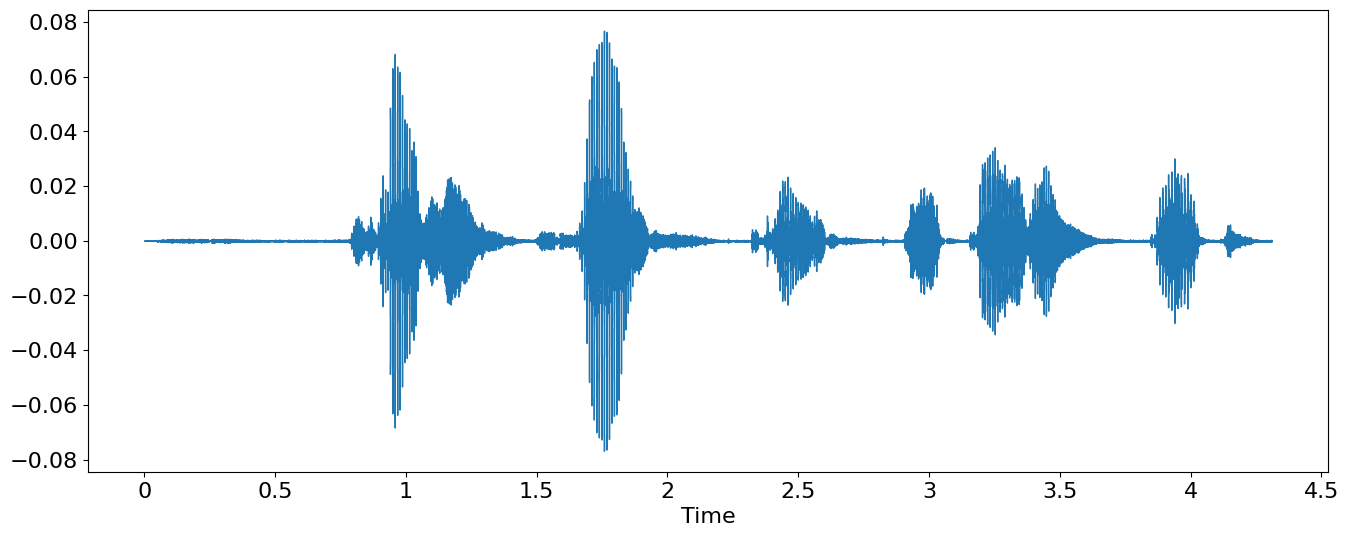

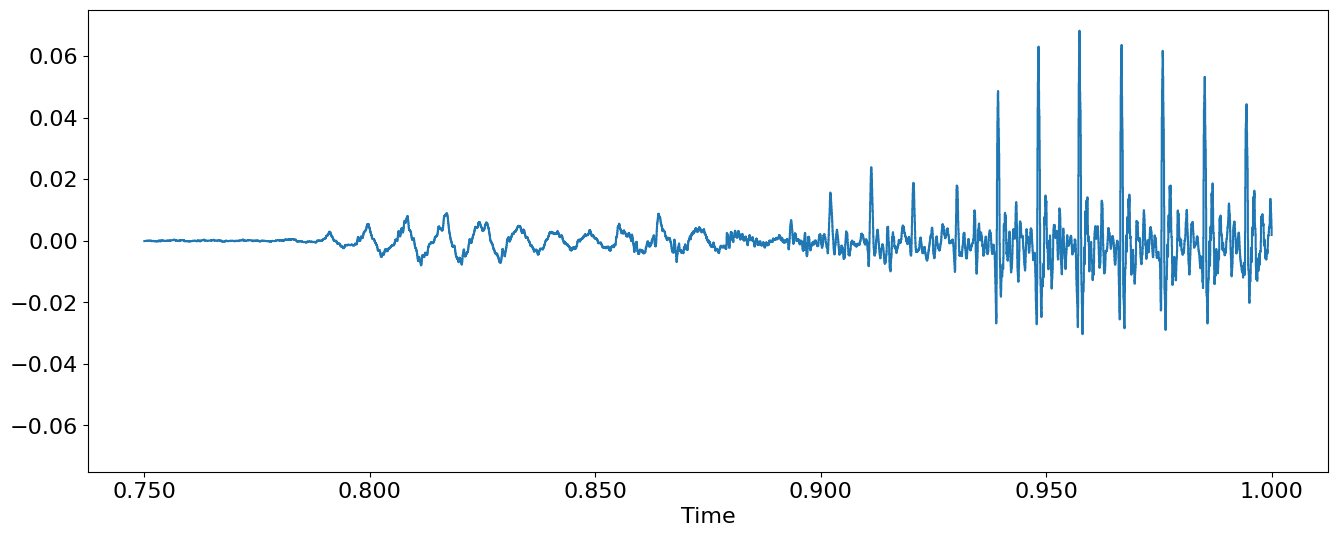

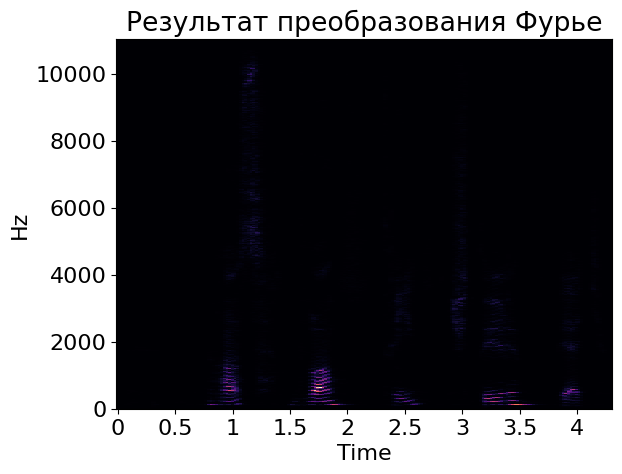

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 16

# считаем аудио
samples, sample_rate = librosa.load('audio.mp3') 

# нарисуем "как есть"
plt.figure(figsize=(16, 6))
librosa.display.waveshow(samples, sr=sample_rate)
plt.show()

plt.figure(figsize=(16, 6))
librosa.display.waveshow(samples[int(0.75*sample_rate): int(1.0* sample_rate)], sr=sample_rate, offset=0.75)
plt.show()

# Нарисуем частостное представление. То, которое получается после преобразования Фурье

sgram = librosa.stft(samples) 
sgram_mag, _ = librosa.magphase(sgram)  # Преобразование Фурье - комплекснозначное. Оставим вещественную часть.
ax = librosa.display.specshow(sgram_mag,sr=sample_rate,y_axis='linear', x_axis='time').axes
ax.label_outer()
ax.set_title('Результат преобразования Фурье')
plt.show()


Выглядит не очень-то ясно. Одна из проблем состоит в том, что наша диаграмма представлена в линейных шкалах, а люди слышат нелинейно. Наша вертикальная ось - частоты в герцах, а интенсивность цвета - это амплитуда сигнала "как есть". Давайте перерисуем диаграмму в мелах и децибелах. Только сначала разберёмся, что это такое.

Мел - единица измерения частоты, но связанная с частотой в герцах логарифмически. Точнее, по такой формуле:

<img src=images/mel_formula.png width=400>

Шкала в мелах появилась по результатам множества экспериментов с людьми и её смысл в том, чтобы расстояние в 1 мел слышалось одинаково "большим", вне зависимости от того, каковы абсолютные значения. Людям кажется, что между звуками с частотой 1000 и 1100 герц расстояние сильно больше, чем между звуками с частотой 10000 и 10100. Со шкалой мелов это не так, одинаковое расстояние в мелах соответствует одинаковому субъективному расстоянию между звуками для среднего человека


<img src=images/Mel-Hz_plot.svg.png width=1200>

Децибелы - это похожая концепция, но для амплитуды нашего сигнала. Громкость люди тоже воспринимают нелинейно, поэтому шкала децибелов такова, что если фактическая амплитуда сигнала возрасла **в** 10 раз, то значение в децибелах увеличится **на** 10 пунктов.

// Вообще - нелинейное, а логарифмическое восприятие раздражителей в целом характерно для человеков. Это свойство известно под названием [закон Вебера — Фехнера](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%BA%D0%BE%D0%BD_%D0%92%D0%B5%D0%B1%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%A4%D0%B5%D1%85%D0%BD%D0%B5%D1%80%D0%B0)

Перерисуем нашу спектрограмму в мелах и децибелах!


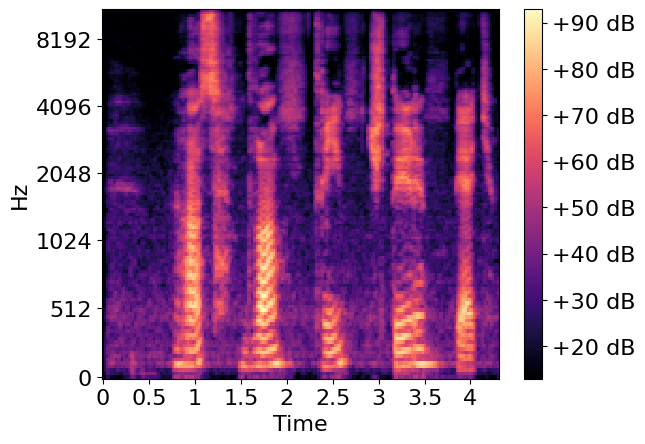

In [2]:
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

Стало гораздо красивее:) То, что на таком представлении данных, и модели лучше учатся - проверено эмпирически, строгих доказательств не будет. 

## Постановка задачи распознавания речи

Итак, все пререквизиты есть. Пора формулировать задачу машинного обучения.

* Входные данные - аудио. В каком-то формате, по умолчанию мел-спектрограммы
* Выходные данные - строка текста.
* Лосс - 🤔

### CTC loss

Давным-давно, когда по земле ходили динозавры, а нейросети были уделом горстки учёных, и ничего не работало на реальных задачах (в 2006 году, то есть), Alex Graves взял и [придумал](https://www.cs.toronto.edu/~graves/icml_2006.pdf) лосс, на который потом стали учиться почти все модели распознавания речи. Подробные объяснения есть [тут](https://distill.pub/2017/ctc/), в нашу лекцию скопирую лишь несколько картинок в качастве иллюстраций к речи.

<img src=images/ctc.png width=1400>

---

<img src=images/many_ctc.png width=1200>

---

<img src=images/dp.png width=1200>

---

<img src=images/ctc_encoder.png>



### RNN-t loss

Снова Alex Graves, 2012 год, [новый лосс](https://arxiv.org/pdf/1211.3711). Идейно очень похож на CTC, за счёт магии динамического программирования редуцируем сложность задачи "похвали модель за все верные пути, и поругай за все неверные". Различие в том, что тут разрешено на один токен аудио порождать несколько токенов текста.

<img src=images/rnnt.png width=600>


## Чисто свёрточные архитектуры: QuartzNet, JasperNet, etc



<img src=images/jasper.png width=800>
<img src=images/quartz.png width=800>

Немного про TCSConv (Time-Channel Separable Convolution), по материалам [отсюда](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728).

<img src=images/OrigConv.png width=800>

---

<img src=images/depthwise.png width=800>

<img src=images/pointwise.png width=800>


Давайте посчитаем количество умножений, которое нам надо выполнить в оригинальной свертке. Имеется 256 ядер размером 5x5x3, которые перемещаются 8x8 раз. Это 256x3x5x5x8x8 = 1_228_800 умножений.

Что насчет separable свертки? В depthwise свертке у нас есть 3 ядра размером 5x5x1, которые перемещаются 8x8 раз. Это 3x5x5x8x8 = 4_800 умножений. В pointwise свертке у нас есть 256 ядер размером 1x1x3, которые перемещаются 8x8 раз. Это 256x1x1x3x8x8=49_152 умножения. Сложив их вместе, получаем 53,952 умножения.

53_952 гораздо меньше, чем 1_228_800. С меньшим количеством вычислений, сеть способна обрабатывать больше данных за меньшее время. Возможно, меньшее число параметров окажет негативное влияние на качество, а может они были избыточны и толком не выучивались, нужно проверять.

В упомянутом выше QuatzNet свёртки оперируют одномерными данными (потому что звук, а не картинка), но все рассуждения о меньшем числе параметров сохраняются.

## Conformer



Ну куда же без трансформеров в наше время. В настоящий момент (2024 год), Conformer - крепкое и достойное решение для прода, если вам приходится хоть сколько-то думать о цене на ГПУ и электричество. Работает заметно лучше чисто свёрточных историй, однако, требует больше ресурсов. Но всё ещё достаточно эффективно: можно юзать, даже если вы не Гугл или Яндекс.

<img src=images/conf1.png width=600>

---

<img src=images/conf2.png width=1600>


## Whisper

Штука от OpenAI. Хронологически самая модная из представленного. Умеет в ASR, в перевод на другой язык, в пунктуацию и форматрование. Очень крепкое решение, если  у вас нет ничего, а вам нужен ASR. Однако, модель сильно тяжелее предыдущих и может галлюцинировать, прям выдумывая несуществующие куски, т.к. энкодер-декодерная архитектура. Заметно хуже работает на коротких аудио (3-8 секунд).

<img src=images/whisper.png width=1600>


## Демонстрация Whisper

In [3]:
import whisper

model = whisper.load_model("medium")

/home/alexandr/Desktop/work/ml2023/venv/lib/python3.11/site-packages/whisper/__init__.py:69: UserWarning: /home/alexandr/.cache/whisper/medium.pt exists, but the SHA256 checksum does not match; re-downloading the file
  warnings.warn(
100%|█████████████████████████████████████| 1.42G/1.42G [01:21<00:00, 18.8MiB/s]


Base-модель работает похуже, чем medium, но сильно легче, примерно 150 мегабайт.

In [4]:
audio = whisper.load_audio("audio.mp3")
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions()
result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)

Detected language: ru
1 2 3 4 5


In [5]:
audio = whisper.load_audio("audio_long.mp3")
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions()
result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)

Detected language: ru
Теперь я скажу что-нибудь более естественное для русского языка и подольше чем 5 секунд. А сейчас я повторю то же самое. Раз, два, три, четыре, пять.


In [6]:
audio = whisper.load_audio("audio_long.mp3")
audio = whisper.pad_or_trim(audio)

# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

# decode the audio
options = whisper.DecodingOptions(language='En')
result = whisper.decode(model, mel, options)

# print the recognized text
print(result.text)

Detected language: ru
Now I will say something more natural for the Russian language and longer than 5 seconds. And now I will repeat the same thing. One, two, three, four, five.


## Ссылки

- [Оригинальная статья](https://www.cs.toronto.edu/~graves/icml_2006.pdf) про CTC-loss
- [Блогпост](https://distill.pub/2017/ctc/) с человеколюбивым объяснением CTC-loss 
- [Блогпост](https://lorenlugosch.github.io/posts/2020/11/transducer/) про CTC и RNN-t лоссы.
- [Блогпост](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53) про мел-спектрограммы. Нужен VPN, т.к. Meduim
- [Блогпост](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728) про разные типы свёрток